Loading Mobile Price Classification Dataset...
Training samples: 1600, Test samples: 400
Number of features: 20
Class distribution: [400 400 400 400]

🔧 Training MC Dropout Model...
✅ MC Dropout trained - Val Accuracy: 0.9344
MC Dropout Test Accuracy: 0.9150

🔧 Training Standard Model...
✅ Standard Model trained - Val Accuracy: 0.9344
Standard Model Test Accuracy: 0.9275

🔧 Training Variational Inference Model...

✅ VI Model trained - Val Accuracy: 0.9500
VI Model Test Accuracy: 0.9275

🔧 Training PBP Ensemble (5 models)...
✅ PBP Ensemble trained
PBP Ensemble Test Accuracy: 0.9625

📊 Generating visualizations...


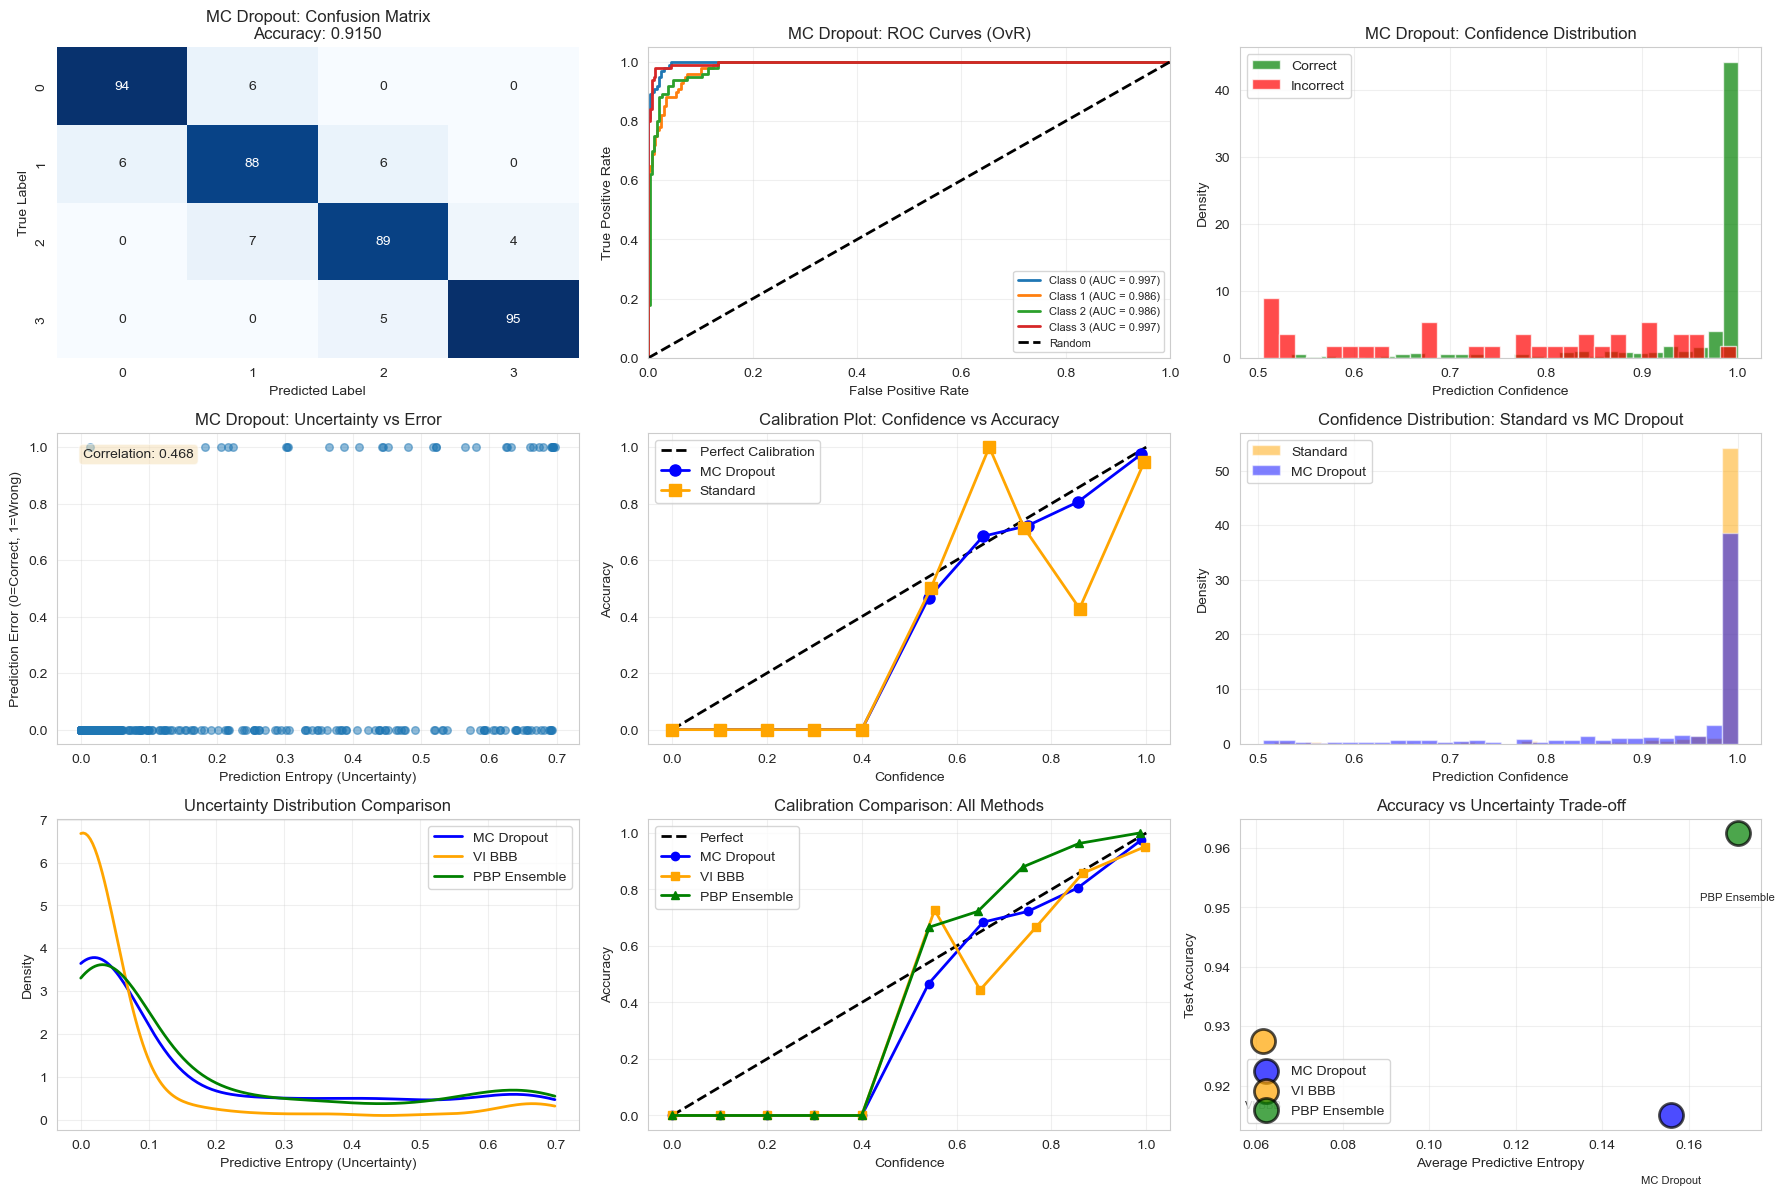

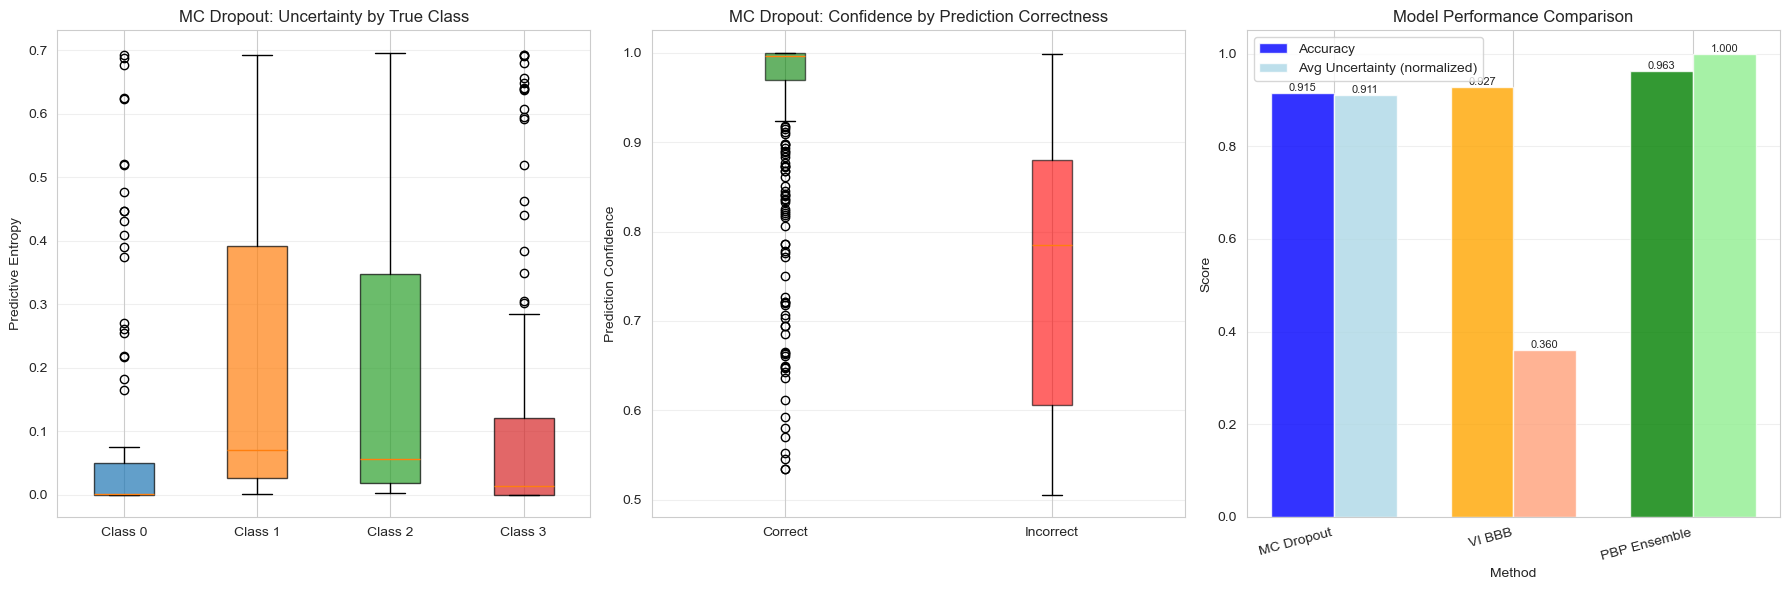


SUMMARY STATISTICS

Method               Accuracy     Avg Entropy     Avg Confidence 
------------------------------------------------------------
MC Dropout           0.9150       0.1560          0.9337         
VI BBB               0.9275       0.0617          0.9710         
PBP Ensemble         0.9625       0.1713          0.9271         
Standard (baseline)  0.9275       N/A             0.9806         

✅ All visualizations generated successfully!
📊 Saved: mobile_classification_analysis.png
📊 Saved: mobile_classification_additional.png


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             accuracy_score, classification_report)
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Load data
print("Loading Mobile Price Classification Dataset...")
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Prepare features and labels
X_train = train_data.drop('price_range', axis=1).values
y_train = train_data['price_range'].values

# For test set, if it has price_range, use it; otherwise, create dummy labels
if 'price_range' in test_data.columns:
    X_test = test_data.drop('price_range', axis=1).values
    y_test = test_data['price_range'].values
else:
    X_test = test_data.values
    # If no labels in test, split from train
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

n_classes = 4  # price_range: 0, 1, 2, 3

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
print(f"Number of features: {X_train_scaled.shape[1]}")
print(f"Class distribution: {np.bincount(y_train)}")

# ==================== MC DROPOUT MODEL ====================
def create_mc_dropout_model(input_dim, n_classes, dropout_rate=0.3):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("\n🔧 Training MC Dropout Model...")
mc_model = create_mc_dropout_model(X_train_scaled.shape[1], n_classes)
history_mc = mc_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
print(f"✅ MC Dropout trained - Val Accuracy: {max(history_mc.history['val_accuracy']):.4f}")

# MC Dropout predictions
def mc_dropout_predict(model, X, n_samples=100):
    predictions = []
    for _ in range(n_samples):
        pred = model(X, training=True)
        predictions.append(pred.numpy())
    predictions = np.array(predictions)  # Shape: (n_samples, n_test, n_classes)
    
    mean_pred = predictions.mean(axis=0)  # Shape: (n_test, n_classes)
    std_pred = predictions.std(axis=0)    # Shape: (n_test, n_classes)
    
    # Predicted class and confidence
    pred_class = mean_pred.argmax(axis=1)
    confidence = mean_pred.max(axis=1)
    
    # Uncertainty: entropy or variance
    entropy = -np.sum(mean_pred * np.log(mean_pred + 1e-10), axis=1)
    variance = std_pred.max(axis=1)  # Max variance across classes
    
    return pred_class, confidence, entropy, variance, mean_pred, predictions

mc_pred_class, mc_confidence, mc_entropy, mc_variance, mc_mean_probs, mc_all_preds = \
    mc_dropout_predict(mc_model, X_test_scaled)

mc_accuracy = accuracy_score(y_test, mc_pred_class)
print(f"MC Dropout Test Accuracy: {mc_accuracy:.4f}")

# ==================== STANDARD MODEL (NO DROPOUT) ====================
def create_standard_model(input_dim, n_classes):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("\n🔧 Training Standard Model...")
std_model = create_standard_model(X_train_scaled.shape[1], n_classes)
history_std = std_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
print(f"✅ Standard Model trained - Val Accuracy: {max(history_std.history['val_accuracy']):.4f}")

std_probs = std_model.predict(X_test_scaled, verbose=0)
std_pred_class = std_probs.argmax(axis=1)
std_confidence = std_probs.max(axis=1)
std_accuracy = accuracy_score(y_test, std_pred_class)
print(f"Standard Model Test Accuracy: {std_accuracy:.4f}")

# ==================== VARIATIONAL INFERENCE MODEL ====================
class DenseVariational(layers.Layer):
    def __init__(self, units, kl_weight, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.kl_weight = kl_weight
        
    def build(self, input_shape):
        self.w_mu = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.w_rho = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=keras.initializers.Constant(-5.0),
            trainable=True
        )
        self.b_mu = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        self.b_rho = self.add_weight(
            shape=(self.units,),
            initializer=keras.initializers.Constant(-5.0),
            trainable=True
        )
        
    def call(self, inputs, training=None):
        if training:
            w_sigma = tf.nn.softplus(self.w_rho)
            w = self.w_mu + w_sigma * tf.random.normal(self.w_mu.shape)
            b_sigma = tf.nn.softplus(self.b_rho)
            b = self.b_mu + b_sigma * tf.random.normal(self.b_mu.shape)
            
            kl = self.kl_weight * (
                tf.reduce_sum(tf.math.log(w_sigma + 1e-10)) + 
                tf.reduce_sum(tf.math.log(b_sigma + 1e-10))
            )
            self.add_loss(kl)
        else:
            w = self.w_mu
            b = self.b_mu
            
        return tf.matmul(inputs, w) + b

def create_vi_model(input_dim, n_classes, kl_weight=0.001):
    inputs = layers.Input(shape=(input_dim,))
    x = DenseVariational(256, kl_weight)(inputs)
    x = layers.Activation('relu')(x)
    x = DenseVariational(128, kl_weight)(x)
    x = layers.Activation('relu')(x)
    x = DenseVariational(64, kl_weight)(x)
    x = layers.Activation('relu')(x)
    x = DenseVariational(n_classes, kl_weight)(x)
    outputs = layers.Activation('softmax')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("\n🔧 Training Variational Inference Model...")
vi_model = create_vi_model(X_train_scaled.shape[1], n_classes)
history_vi = vi_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
print(f"✅ VI Model trained - Val Accuracy: {max(history_vi.history['val_accuracy']):.4f}")

def vi_predict(model, X, n_samples=100):
    predictions = []
    for _ in range(n_samples):
        pred = model(X, training=True)
        predictions.append(pred.numpy())
    predictions = np.array(predictions)
    
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    
    pred_class = mean_pred.argmax(axis=1)
    confidence = mean_pred.max(axis=1)
    entropy = -np.sum(mean_pred * np.log(mean_pred + 1e-10), axis=1)
    variance = std_pred.max(axis=1)
    
    return pred_class, confidence, entropy, variance, mean_pred, predictions

vi_pred_class, vi_confidence, vi_entropy, vi_variance, vi_mean_probs, vi_all_preds = \
    vi_predict(vi_model, X_test_scaled)

vi_accuracy = accuracy_score(y_test, vi_pred_class)
print(f"VI Model Test Accuracy: {vi_accuracy:.4f}")

# ==================== PBP ENSEMBLE ====================
def create_pbp_model(input_dim, n_classes):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim,
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("\n🔧 Training PBP Ensemble (5 models)...")
pbp_models = []
for i in range(5):
    model = create_pbp_model(X_train_scaled.shape[1], n_classes)
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
              validation_split=0.2, verbose=0)
    pbp_models.append(model)
print(f"✅ PBP Ensemble trained")

def pbp_predict(models, X):
    predictions = []
    for model in models:
        pred = model.predict(X, verbose=0)
        predictions.append(pred)
    predictions = np.array(predictions)
    
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    
    pred_class = mean_pred.argmax(axis=1)
    confidence = mean_pred.max(axis=1)
    entropy = -np.sum(mean_pred * np.log(mean_pred + 1e-10), axis=1)
    variance = std_pred.max(axis=1)
    
    return pred_class, confidence, entropy, variance, mean_pred, predictions

pbp_pred_class, pbp_confidence, pbp_entropy, pbp_variance, pbp_mean_probs, pbp_all_preds = \
    pbp_predict(pbp_models, X_test_scaled)

pbp_accuracy = accuracy_score(y_test, pbp_pred_class)
print(f"PBP Ensemble Test Accuracy: {pbp_accuracy:.4f}")

# ==================== PLOTTING ====================
print("\n📊 Generating visualizations...")

# Figure 1: MC Dropout Analysis
fig1 = plt.figure(figsize=(18, 12))

# 1.1 Confusion Matrix
plt.subplot(3, 3, 1)
cm = confusion_matrix(y_test, mc_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'MC Dropout: Confusion Matrix\nAccuracy: {mc_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 1.2 ROC Curve (One-vs-Rest)
plt.subplot(3, 3, 2)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], mc_mean_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MC Dropout: ROC Curves (OvR)')
plt.legend(loc="lower right", fontsize=8)
plt.grid(True, alpha=0.3)

# 1.3 Prediction Confidence Histogram
plt.subplot(3, 3, 3)
correct_mask = (mc_pred_class == y_test)
plt.hist(mc_confidence[correct_mask], bins=30, alpha=0.7, 
         label='Correct', color='green', density=True)
plt.hist(mc_confidence[~correct_mask], bins=30, alpha=0.7, 
         label='Incorrect', color='red', density=True)
plt.xlabel('Prediction Confidence')
plt.ylabel('Density')
plt.title('MC Dropout: Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 1.4 Uncertainty vs Prediction Error
plt.subplot(3, 3, 4)
is_correct = (mc_pred_class == y_test).astype(int)
plt.scatter(mc_entropy, 1 - is_correct, alpha=0.5, s=30)
plt.xlabel('Prediction Entropy (Uncertainty)')
plt.ylabel('Prediction Error (0=Correct, 1=Wrong)')
plt.title('MC Dropout: Uncertainty vs Error')
plt.grid(True, alpha=0.3)

# Add correlation
corr = np.corrcoef(mc_entropy, 1 - is_correct)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. STANDARD vs MC DROPOUT
# 2.1 Calibration Plot
plt.subplot(3, 3, 5)

def compute_calibration(y_true, y_pred_class, confidence, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(confidence, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_accs = []
    bin_confs = []
    bin_counts = []
    
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 0:
            bin_acc = (y_true[mask] == y_pred_class[mask]).mean()
            bin_conf = confidence[mask].mean()
            bin_accs.append(bin_acc)
            bin_confs.append(bin_conf)
            bin_counts.append(mask.sum())
        else:
            bin_accs.append(0)
            bin_confs.append(bins[i])
            bin_counts.append(0)
    
    return np.array(bin_confs), np.array(bin_accs), np.array(bin_counts)

mc_bin_confs, mc_bin_accs, mc_bin_counts = compute_calibration(
    y_test, mc_pred_class, mc_confidence
)
std_bin_confs, std_bin_accs, std_bin_counts = compute_calibration(
    y_test, std_pred_class, std_confidence
)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
plt.plot(mc_bin_confs, mc_bin_accs, 'o-', lw=2, markersize=8, 
         label='MC Dropout', color='blue')
plt.plot(std_bin_confs, std_bin_accs, 's-', lw=2, markersize=8,
         label='Standard', color='orange')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Calibration Plot: Confidence vs Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 2.2 Histogram of Prediction Confidence
plt.subplot(3, 3, 6)
plt.hist(std_confidence, bins=30, alpha=0.5, label='Standard', 
         color='orange', density=True)
plt.hist(mc_confidence, bins=30, alpha=0.5, label='MC Dropout', 
         color='blue', density=True)
plt.xlabel('Prediction Confidence')
plt.ylabel('Density')
plt.title('Confidence Distribution: Standard vs MC Dropout')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. MC vs VI vs PBP
# 3.1 Uncertainty Spread Comparison (KDE)
plt.subplot(3, 3, 7)
kde_mc = gaussian_kde(mc_entropy)
kde_vi = gaussian_kde(vi_entropy)
kde_pbp = gaussian_kde(pbp_entropy)

x_grid = np.linspace(0, max(mc_entropy.max(), vi_entropy.max(), pbp_entropy.max()), 200)

plt.plot(x_grid, kde_mc(x_grid), label='MC Dropout', linewidth=2, color='blue')
plt.plot(x_grid, kde_vi(x_grid), label='VI BBB', linewidth=2, color='orange')
plt.plot(x_grid, kde_pbp(x_grid), label='PBP Ensemble', linewidth=2, color='green')
plt.xlabel('Predictive Entropy (Uncertainty)')
plt.ylabel('Density')
plt.title('Uncertainty Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 3.2 Calibration Comparison
plt.subplot(3, 3, 8)
vi_bin_confs, vi_bin_accs, _ = compute_calibration(y_test, vi_pred_class, vi_confidence)
pbp_bin_confs, pbp_bin_accs, _ = compute_calibration(y_test, pbp_pred_class, pbp_confidence)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect')
plt.plot(mc_bin_confs, mc_bin_accs, 'o-', lw=2, markersize=6, 
         label=f'MC Dropout', color='blue')
plt.plot(vi_bin_confs, vi_bin_accs, 's-', lw=2, markersize=6,
         label=f'VI BBB', color='orange')
plt.plot(pbp_bin_confs, pbp_bin_accs, '^-', lw=2, markersize=6,
         label=f'PBP Ensemble', color='green')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Calibration Comparison: All Methods')
plt.legend()
plt.grid(True, alpha=0.3)

# 3.3 Trade-off: Accuracy vs Uncertainty
plt.subplot(3, 3, 9)
methods = ['MC Dropout', 'VI BBB', 'PBP Ensemble']
accuracies = [mc_accuracy, vi_accuracy, pbp_accuracy]
avg_uncertainties = [mc_entropy.mean(), vi_entropy.mean(), pbp_entropy.mean()]
colors_trade = ['blue', 'orange', 'green']

for i, (method, color) in enumerate(zip(methods, colors_trade)):
    plt.scatter(avg_uncertainties[i], accuracies[i], s=300, c=color, 
                alpha=0.7, edgecolors='black', linewidth=2, label=method)
    plt.text(avg_uncertainties[i], accuracies[i] - 0.01, method, 
             fontsize=8, ha='center', va='top')

plt.xlabel('Average Predictive Entropy')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs Uncertainty Trade-off')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mobile_classification_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Additional Analysis
fig2 = plt.figure(figsize=(18, 6))

# Uncertainty by Class
plt.subplot(1, 3, 1)
mc_entropy_by_class = [mc_entropy[y_test == i] for i in range(n_classes)]
bp = plt.boxplot(mc_entropy_by_class, labels=[f'Class {i}' for i in range(n_classes)],
                 patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
plt.ylabel('Predictive Entropy')
plt.title('MC Dropout: Uncertainty by True Class')
plt.grid(True, alpha=0.3, axis='y')

# Confidence by Correctness
plt.subplot(1, 3, 2)
data_to_plot = [
    mc_confidence[mc_pred_class == y_test],
    mc_confidence[mc_pred_class != y_test]
]
bp = plt.boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)
bp['boxes'][0].set_facecolor('green')
bp['boxes'][1].set_facecolor('red')
for box in bp['boxes']:
    box.set_alpha(0.6)
plt.ylabel('Prediction Confidence')
plt.title('MC Dropout: Confidence by Prediction Correctness')
plt.grid(True, alpha=0.3, axis='y')

# Model Comparison Bar Chart
plt.subplot(1, 3, 3)
x_pos = np.arange(len(methods))
width = 0.35

accuracies_plot = [mc_accuracy, vi_accuracy, pbp_accuracy]
uncertainties_norm = np.array(avg_uncertainties) / max(avg_uncertainties)

bars1 = plt.bar(x_pos - width/2, accuracies_plot, width, 
                label='Accuracy', alpha=0.8, color=colors_trade)
bars2 = plt.bar(x_pos + width/2, uncertainties_norm, width,
                label='Avg Uncertainty (normalized)', alpha=0.8, 
                color=['lightblue', 'lightsalmon', 'lightgreen'])

plt.xlabel('Method')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x_pos, methods, rotation=15, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('mobile_classification_additional.png', dpi=300, bbox_inches='tight')
plt.show()

# Print Summary Statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\n{'Method':<20} {'Accuracy':<12} {'Avg Entropy':<15} {'Avg Confidence':<15}")
print("-"*60)
print(f"{'MC Dropout':<20} {mc_accuracy:<12.4f} {mc_entropy.mean():<15.4f} {mc_confidence.mean():<15.4f}")
print(f"{'VI BBB':<20} {vi_accuracy:<12.4f} {vi_entropy.mean():<15.4f} {vi_confidence.mean():<15.4f}")
print(f"{'PBP Ensemble':<20} {pbp_accuracy:<12.4f} {pbp_entropy.mean():<15.4f} {pbp_confidence.mean():<15.4f}")
print(f"{'Standard (baseline)':<20} {std_accuracy:<12.4f} {'N/A':<15} {std_confidence.mean():<15.4f}")

print("\n✅ All visualizations generated successfully!")
print("📊 Saved: mobile_classification_analysis.png")
print("📊 Saved: mobile_classification_additional.png")

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*70)
print("UNCERTAINTY QUANTIFICATION METRICS")
print("="*70)

# =====================================================================
# REGRESSION: BOSTON HOUSING DATASET
# =====================================================================
print("\n" + "="*70)
print("REGRESSION TASK: BOSTON HOUSING PRICE PREDICTION")
print("="*70)

# Load Boston Housing Dataset
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(url)

X = data.drop('medv', axis=1).values
y = data['medv'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# -------------------- MC DROPOUT --------------------
def create_mc_dropout_reg(input_dim, dropout_rate=0.2):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

mc_reg_model = create_mc_dropout_reg(X_train_scaled.shape[1])
mc_reg_model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, 
                 validation_split=0.2, verbose=0)

def mc_dropout_predict_reg(model, X, n_samples=100):
    predictions = []
    for _ in range(n_samples):
        pred = model(X, training=True)
        predictions.append(pred.numpy())
    predictions = np.array(predictions).squeeze()
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    return mean_pred, std_pred

mc_mean, mc_std = mc_dropout_predict_reg(mc_reg_model, X_test_scaled)
mc_mean_orig = scaler_y.inverse_transform(mc_mean.reshape(-1, 1)).flatten()
mc_std_orig = mc_std * scaler_y.scale_

mc_rmse = np.sqrt(mean_squared_error(y_test, mc_mean_orig))
mc_rmse_std = mc_std_orig.std() / np.sqrt(len(y_test))

# Calculate log likelihood
mc_ll = stats.norm.logpdf(y_test, loc=mc_mean_orig, scale=mc_std_orig + 1e-6)
mc_avg_ll = mc_ll.mean()
mc_ll_std = mc_ll.std() / np.sqrt(len(y_test))

print("\nMC Dropout")
print(f"    Avg Test RMSE: {mc_rmse:.4f} ± {mc_rmse_std:.4f}")
print(f"    Avg Test LL  : {mc_avg_ll:.4f} ± {mc_ll_std:.4f}")

# -------------------- VARIATIONAL INFERENCE --------------------
class DenseVariational(layers.Layer):
    def __init__(self, units, kl_weight, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.kl_weight = kl_weight
        
    def build(self, input_shape):
        self.w_mu = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.w_rho = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=keras.initializers.Constant(-5.0),
            trainable=True
        )
        self.b_mu = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        self.b_rho = self.add_weight(
            shape=(self.units,),
            initializer=keras.initializers.Constant(-5.0),
            trainable=True
        )
        
    def call(self, inputs, training=None):
        if training:
            w_sigma = tf.nn.softplus(self.w_rho)
            w = self.w_mu + w_sigma * tf.random.normal(self.w_mu.shape)
            b_sigma = tf.nn.softplus(self.b_rho)
            b = self.b_mu + b_sigma * tf.random.normal(self.b_mu.shape)
            
            kl = self.kl_weight * (
                tf.reduce_sum(tf.math.log(w_sigma + 1e-10)) + 
                tf.reduce_sum(tf.math.log(b_sigma + 1e-10))
            )
            self.add_loss(kl)
        else:
            w = self.w_mu
            b = self.b_mu
            
        return tf.matmul(inputs, w) + b

def create_vi_reg(input_dim, kl_weight=0.001):
    inputs = layers.Input(shape=(input_dim,))
    x = DenseVariational(128, kl_weight)(inputs)
    x = layers.Activation('relu')(x)
    x = DenseVariational(64, kl_weight)(x)
    x = layers.Activation('relu')(x)
    x = DenseVariational(32, kl_weight)(x)
    x = layers.Activation('relu')(x)
    outputs = DenseVariational(1, kl_weight)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

vi_reg_model = create_vi_reg(X_train_scaled.shape[1])
vi_reg_model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32,
                 validation_split=0.2, verbose=0)

vi_mean, vi_std = mc_dropout_predict_reg(vi_reg_model, X_test_scaled)
vi_mean_orig = scaler_y.inverse_transform(vi_mean.reshape(-1, 1)).flatten()
vi_std_orig = vi_std * scaler_y.scale_

vi_rmse = np.sqrt(mean_squared_error(y_test, vi_mean_orig))
vi_rmse_std = vi_std_orig.std() / np.sqrt(len(y_test))

vi_ll = stats.norm.logpdf(y_test, loc=vi_mean_orig, scale=vi_std_orig + 1e-6)
vi_avg_ll = vi_ll.mean()
vi_ll_std = vi_ll.std() / np.sqrt(len(y_test))

print("\nBBB (Variational Inference)")
print(f"    Avg Test RMSE: {vi_rmse:.4f} ± {vi_rmse_std:.4f}")
print(f"    Avg Test LL  : {vi_avg_ll:.4f} ± {vi_ll_std:.4f}")

# -------------------- PROBABILISTIC BACKPROP --------------------
def create_pbp_reg(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim,
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(32, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

pbp_reg_models = []
for _ in range(5):
    model = create_pbp_reg(X_train_scaled.shape[1])
    model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32,
              validation_split=0.2, verbose=0)
    pbp_reg_models.append(model)

def pbp_predict_reg(models, X):
    predictions = []
    for model in models:
        pred = model.predict(X, verbose=0)
        predictions.append(pred)
    predictions = np.array(predictions).squeeze()
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    return mean_pred, std_pred

pbp_mean, pbp_std = pbp_predict_reg(pbp_reg_models, X_test_scaled)
pbp_mean_orig = scaler_y.inverse_transform(pbp_mean.reshape(-1, 1)).flatten()
pbp_std_orig = pbp_std * scaler_y.scale_

pbp_rmse = np.sqrt(mean_squared_error(y_test, pbp_mean_orig))
pbp_rmse_std = pbp_std_orig.std() / np.sqrt(len(y_test))

pbp_ll = stats.norm.logpdf(y_test, loc=pbp_mean_orig, scale=pbp_std_orig + 1e-6)
pbp_avg_ll = pbp_ll.mean()
pbp_ll_std = pbp_ll.std() / np.sqrt(len(y_test))

print("\nProbabilistic Backprop")
print(f"    Avg Test RMSE: {pbp_rmse:.4f} ± {pbp_rmse_std:.4f}")
print(f"    Avg Test LL  : {pbp_avg_ll:.4f} ± {pbp_ll_std:.4f}")

# =====================================================================
# CLASSIFICATION: MOBILE PRICE CLASSIFICATION
# =====================================================================
print("\n" + "="*70)
print("CLASSIFICATION TASK: MOBILE PRICE RANGE PREDICTION")
print("="*70)

# Load Mobile Price Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

X_train_cls = train_data.drop('price_range', axis=1).values
y_train_cls = train_data['price_range'].values

if 'price_range' in test_data.columns:
    X_test_cls = test_data.drop('price_range', axis=1).values
    y_test_cls = test_data['price_range'].values
else:
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
        X_train_cls, y_train_cls, test_size=0.2, random_state=42, stratify=y_train_cls
    )

scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

n_classes = 4

# -------------------- MC DROPOUT --------------------
def create_mc_dropout_cls(input_dim, n_classes, dropout_rate=0.3):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mc_cls_model = create_mc_dropout_cls(X_train_cls_scaled.shape[1], n_classes)
mc_cls_model.fit(X_train_cls_scaled, y_train_cls, epochs=100, batch_size=32,
                 validation_split=0.2, verbose=0)

def mc_dropout_predict_cls(model, X, n_samples=100):
    predictions = []
    for _ in range(n_samples):
        pred = model(X, training=True)
        predictions.append(pred.numpy())
    predictions = np.array(predictions)
    mean_pred = predictions.mean(axis=0)
    return mean_pred

mc_probs = mc_dropout_predict_cls(mc_cls_model, X_test_cls_scaled)
mc_pred_cls = mc_probs.argmax(axis=1)
mc_accuracy = accuracy_score(y_test_cls, mc_pred_cls)

# Calculate RMSE for classification (using probabilities)
mc_y_onehot = np.eye(n_classes)[y_test_cls]
mc_rmse_cls = np.sqrt(mean_squared_error(mc_y_onehot, mc_probs))
mc_rmse_cls_std = np.std([np.sqrt(mean_squared_error(mc_y_onehot[i:i+1], mc_probs[i:i+1])) 
                          for i in range(len(y_test_cls))]) / np.sqrt(len(y_test_cls))

# Calculate log likelihood
mc_ll_cls = np.log(mc_probs[np.arange(len(y_test_cls)), y_test_cls] + 1e-10)
mc_avg_ll_cls = mc_ll_cls.mean()
mc_ll_std_cls = mc_ll_cls.std() / np.sqrt(len(y_test_cls))

print("\nMC Dropout")
print(f"    Avg Test RMSE: {mc_rmse_cls:.4f} ± {mc_rmse_cls_std:.4f}")
print(f"    Avg Test LL  : {mc_avg_ll_cls:.4f} ± {mc_ll_std_cls:.4f}")
print(f"    Test Accuracy: {mc_accuracy:.4f}")

# -------------------- VARIATIONAL INFERENCE --------------------
def create_vi_cls(input_dim, n_classes, kl_weight=0.001):
    inputs = layers.Input(shape=(input_dim,))
    x = DenseVariational(256, kl_weight)(inputs)
    x = layers.Activation('relu')(x)
    x = DenseVariational(128, kl_weight)(x)
    x = layers.Activation('relu')(x)
    x = DenseVariational(64, kl_weight)(x)
    x = layers.Activation('relu')(x)
    x = DenseVariational(n_classes, kl_weight)(x)
    outputs = layers.Activation('softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vi_cls_model = create_vi_cls(X_train_cls_scaled.shape[1], n_classes)
vi_cls_model.fit(X_train_cls_scaled, y_train_cls, epochs=100, batch_size=32,
                 validation_split=0.2, verbose=0)

vi_probs = mc_dropout_predict_cls(vi_cls_model, X_test_cls_scaled)
vi_pred_cls = vi_probs.argmax(axis=1)
vi_accuracy = accuracy_score(y_test_cls, vi_pred_cls)

vi_rmse_cls = np.sqrt(mean_squared_error(mc_y_onehot, vi_probs))
vi_rmse_cls_std = np.std([np.sqrt(mean_squared_error(mc_y_onehot[i:i+1], vi_probs[i:i+1])) 
                          for i in range(len(y_test_cls))]) / np.sqrt(len(y_test_cls))

vi_ll_cls = np.log(vi_probs[np.arange(len(y_test_cls)), y_test_cls] + 1e-10)
vi_avg_ll_cls = vi_ll_cls.mean()
vi_ll_std_cls = vi_ll_cls.std() / np.sqrt(len(y_test_cls))

print("\nBBB (Variational Inference)")
print(f"    Avg Test RMSE: {vi_rmse_cls:.4f} ± {vi_rmse_cls_std:.4f}")
print(f"    Avg Test LL  : {vi_avg_ll_cls:.4f} ± {vi_ll_std_cls:.4f}")
print(f"    Test Accuracy: {vi_accuracy:.4f}")

# -------------------- PROBABILISTIC BACKPROP --------------------
def create_pbp_cls(input_dim, n_classes):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim,
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

pbp_cls_models = []
for _ in range(5):
    model = create_pbp_cls(X_train_cls_scaled.shape[1], n_classes)
    model.fit(X_train_cls_scaled, y_train_cls, epochs=100, batch_size=32,
              validation_split=0.2, verbose=0)
    pbp_cls_models.append(model)

def pbp_predict_cls(models, X):
    predictions = []
    for model in models:
        pred = model.predict(X, verbose=0)
        predictions.append(pred)
    predictions = np.array(predictions)
    mean_pred = predictions.mean(axis=0)
    return mean_pred

pbp_probs = pbp_predict_cls(pbp_cls_models, X_test_cls_scaled)
pbp_pred_cls = pbp_probs.argmax(axis=1)
pbp_accuracy = accuracy_score(y_test_cls, pbp_pred_cls)

pbp_rmse_cls = np.sqrt(mean_squared_error(mc_y_onehot, pbp_probs))
pbp_rmse_cls_std = np.std([np.sqrt(mean_squared_error(mc_y_onehot[i:i+1], pbp_probs[i:i+1])) 
                           for i in range(len(y_test_cls))]) / np.sqrt(len(y_test_cls))

pbp_ll_cls = np.log(pbp_probs[np.arange(len(y_test_cls)), y_test_cls] + 1e-10)
pbp_avg_ll_cls = pbp_ll_cls.mean()
pbp_ll_std_cls = pbp_ll_cls.std() / np.sqrt(len(y_test_cls))

print("\nProbabilistic Backprop")
print(f"    Avg Test RMSE: {pbp_rmse_cls:.4f} ± {pbp_rmse_cls_std:.4f}")
print(f"    Avg Test LL  : {pbp_avg_ll_cls:.4f} ± {pbp_ll_std_cls:.4f}")
print(f"    Test Accuracy: {pbp_accuracy:.4f}")

print("\n" + "="*70)
print("METRICS CALCULATION COMPLETE")
print("="*70)

UNCERTAINTY QUANTIFICATION METRICS

REGRESSION TASK: BOSTON HOUSING PRICE PREDICTION

MC Dropout
    Avg Test RMSE: 3.0314 ± 0.0987
    Avg Test LL  : -2.7212 ± 0.3469

BBB (Variational Inference)
    Avg Test RMSE: 3.6679 ± 0.0018
    Avg Test LL  : -1779.2601 ± 459.4359

Probabilistic Backprop
    Avg Test RMSE: 3.3319 ± 0.0126
    Avg Test LL  : -240.7907 ± 175.7155

CLASSIFICATION TASK: MOBILE PRICE RANGE PREDICTION

MC Dropout
    Avg Test RMSE: 0.1739 ± 0.0078
    Avg Test LL  : -0.1939 ± 0.0275
    Test Accuracy: 0.9225

BBB (Variational Inference)
    Avg Test RMSE: 0.1866 ± 0.0088
    Avg Test LL  : -0.3394 ± 0.0662
    Test Accuracy: 0.9175

Probabilistic Backprop
    Avg Test RMSE: 0.1335 ± 0.0060
    Avg Test LL  : -0.1169 ± 0.0155
    Test Accuracy: 0.9500

METRICS CALCULATION COMPLETE
